In [1]:
"""
Cross entropy benchmarking of two qubits (XEB) is a method for characterizing the fidelity of a two-qubit gate.
The XEB sequence consists of a random sequence of single-qubit gates and a two-qubit gate, followed by a measurement.
The sequence is repeated many times, and the results are used to calculate the cross entropy between the ideal and measured states.
The cross entropy is a measure of the distance between two probability distributions, and is related to the fidelity of the two-qubit gate.
The cross entropy is calculated as follows:
    1. The ideal state is calculated by applying the sequence of single-qubit gates and the two-qubit gate to the initial state |00>.
    2. The measured state is calculated by applying the sequence of single-qubit gates to the initial state |00>, followed by a measurement.
    3. The cross entropy is calculated between the ideal and measured states.
The cross entropy is calculated for a range of sequence depths, and the results are used to calculate the fidelity of the two-qubit gate.
In this script, we provide an example of how to run an XEB sequence on the OPX.

Author: Arthur Strauss - Quantum Machines
Created: 16/01/2024 (Last modified: 16/01/2024)
"""
import numpy as np
import pandas as pd
import seaborn as sns
from qm import QuantumMachinesManager
from qm.qua import *
from qm.simulate.credentials import create_credentials
from scipy.optimize import curve_fit

import sys
sys.path.append('/Users/adamachuck/Documents/GitHub/PYQUM/TEST/BETAsite/QM/OPXPlus/Configurations')

from configuration import *
from qm.simulate import SimulationConfig
from matplotlib import pyplot as plt
import pprint
from macros import multiplexed_readout, qua_declaration, cz_gate
from qiskit import QuantumCircuit
from qiskit.circuit.library import CZGate, RXGate, RYGate, RZGate, HGate, UnitaryGate, TGate, XGate, YGate, CPhaseGate
from qiskit.quantum_info import Statevector
from time import sleep
from scipy.linalg import sqrtm
import warnings

%matplotlib inline


2024-02-19 15:39:53,884 - qm - INFO     - Starting session: 7d04216b-88e3-44bf-9a2b-fb948598a6bf
Absolute Path: /Users/adamachuck/Documents/GitHub/PYQUM/TEST/BETAsite/QM/OPXPlus/5-Flux-Tunable-Transmons/Standard Configuration
QPU q1 control frequency: 3068593000 Hz
QPU q2 control frequency: 3860772000 Hz
QPU q3 control frequency: 2993228000 Hz
QPU q4 control frequency: 3595872000 Hz
QPU q5 control frequency: 4470751000 Hz


In [3]:
qubits = [4]
qubits_el = [f"q{i}_xy" for i in qubits]
multiplexed = qubits + [x+1 for x in range(5) if (x+1) not in qubits]
print(f"multiplexed: {multiplexed}")

cz_type = "const_wf"
apply_cz = False
if len(qubits) < 2:
    apply_cz = False
    print("CZ gate not applied (less than 2 qubits)")
impose_0_cycle = True

seqs = 30  # 101 # Number of random sequences to run per depth
max_depth = 200  # 7  # Max depth of the XEB sequence
step = 20  # Step for the depth iteration
avgs = 1024  # 101  # Number of averages per sequence
depths = np.arange(1, max_depth+1, step)  # Create an array of depths to iterate through

time_per_point = 15/(101*37*101) # in min
print(f"Estimated runtime: {seqs*avgs*len(depths)*time_per_point} minutes")


multiplexed: [4, 1, 2, 3, 5]
CZ gate not applied (less than 2 qubits)
Estimated runtime: 12.208659988289435 minutes


In [4]:
# Random gates
X90, Y90, Z180 = RXGate(np.pi / 2), RYGate(np.pi / 2), RZGate(np.pi)
Z45 = RZGate(1 * np.pi / 4)
T, X, Y, H = TGate(), XGate(), YGate(), HGate()
W = UnitaryGate((X.to_matrix() + Y.to_matrix())/np.sqrt(2), label='W')
SW = UnitaryGate(sqrtm(W), label='SW')
sw = UnitaryGate(np.array([[1, -np.sqrt(1j)], [np.sqrt(-1j), 1]])/np.sqrt(2)) # from Supremacy paper

XY90 = UnitaryGate((X90.to_matrix() + Y90.to_matrix()) / np.sqrt(3), label="XY90")
# XY90 = UnitaryGate((T.to_matrix() @ X90.to_matrix()), label="XY90")
# XY90 = UnitaryGate((X90.to_matrix() @ T.to_matrix()), label="XY90")

XY90mm = UnitaryGate((-X90.to_matrix() - Y90.to_matrix()) / np.sqrt(3), label="XY90mm")
XY90pm = UnitaryGate((X90.to_matrix() - Y90.to_matrix()), label="XY90pm")
XY90mp = UnitaryGate((-X90.to_matrix() + Y90.to_matrix()), label="XY90mp")
CZ, CP = CZGate(), CPhaseGate(np.pi/2)

X90_dict = {"gate": X90, 'amp_matrix': np.array([1., 0., 0., 1.])}
# Y90_dict = {"gate": Y90, 'amp_matrix': np.array([0., 1., -1., 0.])}
Y90_dict = {"gate": Y90, 'amp_matrix': np.array([0., -1., 1., 0.])} # verified w/ CX
# XY90_dict = {"gate": XY90, 'amp_matrix': 0.70710678 * np.array([1., 1., -1., 1.])}
XY90_dict = {"gate": XY90, 'amp_matrix': 0.70710678 * np.array([1., -1., 1., 1.])} # verified w/ CX

# TODO: For the dicts below, need to check the validity of amplitude matrices!
XY90mm_dict = {"gate": XY90mm, 'amp_matrix': 0.70710678 * np.array([-1., -1., 1., -1.])}
XY90pm_dict = {"gate": XY90pm, 'amp_matrix': 0.70710678 * np.array([1., -1., 1., 1.])}
XY90mp_dict = {"gate": XY90mp, 'amp_matrix': 0.70710678 * np.array([-1., 1., -1., 1.])}
T_dict = {"gate": T, 'amp_matrix': np.array([1., 0., 0., 1])}  # No actual need for amp_matrix,
# but here for consistency with the current workflow
SW_dict = {"gate": sw, 'amp_matrix': 0.70710678 * np.array([1., -1., 1., 1.])}  # Amp matrix similar to XY90

# Possible gate sets
gate_dict1 = {0: X90_dict, 1: Y90_dict, 2: T_dict}  # https://arxiv.org/abs/1608.00263
gate_dict2 = {0: X90_dict, 1: Y90_dict, 2: SW_dict}  # Supremacy gate set (https://www.nature.com/articles/s41586-019-1666-5)
gate_dict3 = {0: X90_dict, 1: Y90_dict, 2: XY90_dict, 3: XY90mm_dict, 4: XY90pm_dict, 5: XY90mp_dict}  # https://arxiv.org/abs/2001.08343
gate_dict4 = {0: X90_dict, 1: Y90_dict, 2: XY90_dict}  # Currently used in the QM XEB example (XY90==XY90pp)
gate_sets = [gate_dict1, gate_dict2, gate_dict3, gate_dict4]

# Choose the gate set
gate_set_choice = 2  # 1, 2, 3 or 4

gate_dict = gate_sets[gate_set_choice - 1]
random_gates = len(gate_dict)


In [40]:
# Check Unitary:
from qiskit.quantum_info import Operator

Operator(XY90).is_unitary()
print(XY90.to_matrix()@XY90.to_matrix().conjugate().transpose())

# print(XY90pm.to_matrix())
# print(W.to_matrix())

print((SW.to_matrix() @ SW.to_matrix()))
print(np.sqrt(W.to_matrix()))
# print((Y90.to_matrix() @ Z180.to_matrix()))

print(np.sqrt(1j))

# from Supremacy's paper:
sw = UnitaryGate(np.array([[1, -np.sqrt(1j)], [np.sqrt(-1j), 1]])/np.sqrt(2))
w = sw.to_matrix() @ sw.to_matrix()
print(f"Supremacy W:\n {w}")

from scipy.linalg import sqrtm
SW = UnitaryGate((sqrtm(W.to_matrix())), label='SW')
print(f"SW**2:\n {SW.to_matrix() @ SW.to_matrix()}")

print(f"W:\n {W.to_matrix()}")


[[ 1.0000000e+00-9.95716912e-18j -9.7278522e-18-9.72785220e-18j]
 [-9.7278522e-18+9.72785220e-18j  1.0000000e+00+9.95716912e-18j]]
[[4.74800169e-16-3.75731123e-16j 7.07106781e-01-7.07106781e-01j]
 [7.07106781e-01+7.07106781e-01j 6.66133815e-16+8.32667268e-17j]]
[[0.        +0.j         0.92387953-0.38268343j]
 [0.92387953+0.38268343j 0.        +0.j        ]]
(0.7071067811865476+0.7071067811865475j)
Supremacy W:
 [[ 0.00000000e+00+1.11022302e-16j -7.07106781e-01-7.07106781e-01j]
 [ 7.07106781e-01-7.07106781e-01j  2.23711432e-17+1.11022302e-16j]]
SW**2:
 [[4.74800169e-16-3.75731123e-16j 7.07106781e-01-7.07106781e-01j]
 [7.07106781e-01+7.07106781e-01j 6.66133815e-16+8.32667268e-17j]]
W:
 [[0.        +0.j         0.70710678-0.70710678j]
 [0.70710678+0.70710678j 0.        +0.j        ]]
False
[4, 1, 2, 3, 5]


In [5]:
qmm = QuantumMachinesManager(host=qop_ip, port=qop_port, cluster_name=cluster_name, octave=octave_config)
# qmm = QuantumMachinesManager(host="tyler-263ed49e.dev.quantum-machines.co", port=443, credentials=create_credentials())
# qubits = ["q0", "q1"]  # Fix which qubits to use on the chip (quantum elements in the configuration)
# readout_elements = ["rr0", "rr1"]  # Fix which readout resonators to use on the chip (readout elements in the
# configuration)
# ge_threshold = 0.1  # Threshold for the ground state population (used for the readout)
# thermalization_time = 100  # Thermalization time for the qubits (in ns)
simulate = False

def assign_amplitude_matrix(gate, a):
    """
    QUA Macro for assigning the amplitude matrix arguments for a given gate index.
    :param gate: Gate index
    :param a: Amplitude matrix arguments
    """
    with switch_(gate):
        for i in range(random_gates):
            with case_(i):
                for j in range(4):
                    assign(a[j], gate_dict[i]['amp_matrix'][j])


# QUA Program

with program() as xeb:
    # Declare QUA variables
    I, I_st, Q, Q_st, n, n_st = qua_declaration(nb_of_qubits=len(multiplexed))
    # I, Q = [declare(fixed) for _ in range(2)], [declare(fixed) for _ in range(2)]
    s, tot_state_ = declare(int), declare(int)
    d, d_ = declare(int), declare(int)
    g = [declare(int, size=max_depth) for _ in range(len(qubits))]  # Gate indices list for both qubits
    a = [[declare(fixed, size=max_depth) for _ in range(4)] for _ in
         range(len(qubits))]  # Amplitude matrices for both qubits (for all depths)
    counts = [declare(int, value=0) for _ in range(2 ** len(qubits))] # Counts for the 4 possible states
    state = [declare(bool) for _ in range(len(multiplexed))] # State of the qubits
    # Declare streams
    # I_st, Q_st = [declare_stream() for _ in range(2)], [declare_stream() for _ in range(2)]
    s_st = declare_stream()
    counts_st = [declare_stream() for _ in range(2**len(qubits))]
    state_st = [declare_stream() for _ in range(len(multiplexed))]
    g_st = [declare_stream() for _ in range(len(qubits))]

    # Randomize the random number generator
    r = Random()
    r.set_seed(12321)
    # r.set_seed(11111)

    # If we are simulating, we need to update the frequency of the qubits to 0 to visualize the sequence
    # if simulate:
    if True:
        a_st = [[declare_stream() for _ in range(4)] for _ in range(len(qubits))]
        # for qubit in qubits_el:
            # update_frequency(qubit, 0)

    # Generate and run the XEB sequences
    with for_(s, 0, s < seqs, s + 1):
        with for_each_(d, depths): # max-depths
            # Randomize the sequence of single-qubit gates
            with for_(d_, 0, d_ < d, d_ + 1):
                for q in range(len(qubits)):
                    assign(g[q][d_], r.rand_int(random_gates)) # different from Google: randomizing for each growing-depths and sequences
                    with if_(d_ > 0):
                        with while_(g[q][d_] == g[q][d_ - 1]):  # Make sure the same gate is not applied twice in a row
                            assign(g[q][d_], r.rand_int(random_gates))
                    # Map the sequence indices into amplitude matrix arguments (each index corresponds to a random gate)
                    assign_amplitude_matrix(g[q][d_], [a[q][i][d_] for i in range(4)])
                    save(g[q][d_], g_st[q])

                    # if simulate:
                    if True:
                        for amp_matrix_element in range(4):
                            save(a[q][amp_matrix_element][d_], a_st[q][amp_matrix_element])

            # Run the XEB sequence
            with for_(n, 0, n < avgs, n + 1):
                # save(n, n_st)
                # Reset the qubits to their ground states (here simple wait but could be an active reset macro)
                if simulate:
                    wait(25, *qubits_el)
                else:
                    wait(3 * thermalization_time, *qubits_el)

                # NOTE: imposing first gate at 0-cycle:
                if impose_0_cycle:
                    for q in range(len(qubits)): 
                        play("x90" * amp(*XY90_dict["amp_matrix"]), qubits_el[q])
                        # play("y90", qubits_el[q])
                        # play("x180", qubits_el[q])

                # Play all cycles generated for sequence s of depth d
                with for_(d_, 0, d_ < d, d_ + 1):
                    for q in range(len(qubits)):  # Play single qubit gates on both qubits
                        if T_dict in gate_dict.values():
                            with switch_(g[q][d_], unsafe=True):
                                for j in range(2):
                                    with case_(j):
                                        play("x90" * amp(*[a[q][i][d_] for i in range(4)]), qubits_el[q])
                                with case_(2):
                                    frame_rotation(np.pi/4, qubits_el[q])
                        elif SW_dict in gate_dict.values():
                            # raise NotImplementedError("SW gate not readily implemented yet")
                            warnings.warn("SW gate not readily implemented yet")
                            play("x90" * amp(*[a[q][i][d_] for i in range(4)]), qubits_el[q])
                        else:
                            play("x90" * amp(*[a[q][i][d_] for i in range(4)]), qubits_el[q])
                    align()
                    if apply_cz:
                        # Insert your two-qubit gate macro here
                        cz_gate(qubits[0], qubits[1], cz_type)
                        frame_rotation_2pi(eval(f"cz{5}_{4}_2pi_dev"), "q5_xy")
                        frame_rotation_2pi(eval(f"cz{4}_{5}_2pi_dev"), "q4_xy")
                    align()

                # Measure the state (insert your readout macro here)
                multiplexed_readout(I, I_st, Q, Q_st, resonators=multiplexed, weights="rotated_")

                # State discrimination
                assign(state[0], I[0] > eval(f"ge_threshold_q{multiplexed[0]}"))
                assign(state[1], I[1] > eval(f"ge_threshold_q{multiplexed[1]}"))
                save(state[0], state_st[0])
                save(state[1], state_st[1])

                # State Estimation: returned as an integer, to be later converted to bitstrings
                for q in range(len(qubits)):
                    assign(tot_state_, tot_state_ + 2**q * Cast.to_int(state[q]))

                # assign(tot_state_, Cast.to_int(state[0]) + 2 * Cast.to_int(state[1]))
                # assign(tot_state_, Cast.to_int(state[1]) + 2 * Cast.to_int(state[0]))
                with switch_(tot_state_):
                    for i in range(2 ** len(qubits)):  # Bitstring conversion
                        with case_(i):
                            assign(counts[i], counts[i] + 1)  # counts for 00, 01, 10 and 11
                assign(tot_state_, 0)
            for i in range(2 ** len(qubits)):  # Resetting Bitstring collection
                save(counts[i], counts_st[i])
                assign(counts[i], 0)

            # Save the sequence iteration to get the progress bar
            save(s, s_st)

    # Save the results
    with stream_processing():
        s_st.save("s")
        for q in range(len(qubits)):
            g_st[q].save_all(f"g{q}")
            I_st[q].buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(f"I{q}")
            Q_st[q].buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(f"Q{q}")
            state_st[q].boolean_to_int().buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(
                f"state{q}")
        for i in range(2**len(qubits)):
            string = "s" + bin(i)[2:].zfill(len(qubits))
            counts_st[i].buffer(len(depths)).save_all(string)

        # if simulate:
        if True:
            for q in range(len(qubits)):
                for d_ in range(4):
                    a_st[q][d_].save_all(f"a{q + 1}_{bin(d_)[2:].zfill(2)}")

if simulate:
    job = qmm.simulate(config, xeb, SimulationConfig(15000))
    job.get_simulated_samples().con1.plot()
    job.get_simulated_samples().con2.plot()
    plt.show()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(xeb)

job.result_handles.wait_for_all_values()
g = [job.result_handles.get(f"g{i}").fetch_all()['value'] for i in range(len(qubits))]

if simulate:
    a = {f"a{q + 1}_{bin(i)[2:].zfill(2)}": job.result_handles.get(f"a{q + 1}_{bin(i)[2:].zfill(2)}").fetch_all()['value'] for q in
         range(len(qubits)) for i in range(4)}
else:
    a = {f"a{q + 1}_{bin(i)[2:].zfill(2)}": job.result_handles.get(f"a{q + 1}_{bin(i)[2:].zfill(2)}").fetch_all()['value'] for q in
     range(len(qubits)) for i in range(4)}
    quadratures = {f"I{i}": job.result_handles.get(f"I{i}").fetch_all()['value'] for i in range(len(qubits))}
    quadratures.update({f"Q{i}": job.result_handles.get(f"Q{i}").fetch_all()['value'] for i in range(len(qubits))})
    
    state = {f"state{i}": job.result_handles.get(f"state{i}").fetch_all()['value'] for i in range(len(qubits))}
    counts = {bin(i)[2:].zfill(len(qubits)): job.result_handles.get(f"s{bin(i)[2:].zfill(len(qubits))}").fetch_all()['value'] for i in range(2**len(qubits))}
    # state1, state2 = [job.result_handles.get(f'state{i}').fetch_all()['value'] for i in [1, 2]]
    # state00, state01, state10, state11 = [job.result_handles.get(f's{bin(i)[2:].zfill(2)}').fetch_all()['value'] for
    #                                       i in
    #                                       range(4)]
    # 
    # print(f"state1:\n {state1}, state2:\n {state2}")
    # print(f"state00:\n {state00}, state01:\n {state01}, state10:\n {state10}, state11:\n {state11}")


    # Close the quantum machines at the end in order to put all flux biases to 0 so that the fridge doesn't heat-up
    qm.close()

    

2024-02-19 15:40:39,681 - qm - INFO     - Octave "octave1" Health check passed, current temperature 58
2024-02-19 15:40:40,589 - qm - INFO     - Octave "octave2" Health check passed, current temperature 57
2024-02-19 15:40:40,590 - qm - INFO     - Performing health check
2024-02-19 15:40:40,607 - qm - INFO     - Health check passed


/var/folders/lz/657q9ypj0pd6l1g7f0wk81hm0000gn/T/ipykernel_66242/1855157407.py:102: UserWarning: SW gate not readily implemented yet
  warnings.warn("SW gate not readily implemented yet")


2024-02-19 15:40:41,910 - qm - INFO     - Sending program to QOP for compilation
2024-02-19 15:40:42,804 - qm - INFO     - Executing program


In [6]:
# Process results (Post-processing)

# Rebuild gate sequences generated from the QUA:
sq_indices = []
idx = 0
for s in range(seqs):
    sq_indices.append([])
    for i, d in enumerate(depths):
        sq_indices[s].append(np.zeros((len(qubits), d), dtype=int))
        for d_ in range(d):
            for q in range(len(qubits)):
                sq_indices[s][i][q][d_] = g[q][idx]
            idx += 1


def cross_entropy(p, q, epsilon=1e-15):
    """
    Calculate cross entropy between two probability distributions.

    Parameters:
    - p: numpy array, the true probability distribution
    - q: numpy array, the predicted probability distribution
    - epsilon: small value to avoid taking the logarithm of zero

    Returns:
    - Cross entropy between p and q
    """
    q = np.maximum(q, epsilon)  # Avoid taking the logarithm of zero

    # print(f"p: {p}, \nq: {q}")

    x_entropy = -np.sum(p * np.log(q))

    return x_entropy

records = []
incoherent_distribution = np.ones(2 ** len(qubits)) / (2 ** len(qubits))
fidelities = np.zeros((seqs, len(depths)))
expected_probs = np.zeros((seqs, len(depths), 2 ** len(qubits)))
measured_probs = np.zeros((seqs, len(depths), 2 ** len(qubits)))

# Reconstruct every Circuit from the previously rebuilt gate sequences: (using Qiskit)
circuits_list = []
singularity = []
for s in range(seqs):
    circuits_list.append([])
    for d_, d in enumerate(depths):
        state = Statevector.from_int(0, 2 ** len(qubits))
        qc = QuantumCircuit(len(qubits))

        # NOTE: imposing first gate at 0-cycle:
        gate_cycle_0 = XY90 # XY90, H
        if impose_0_cycle:
            for i in range(len(qubits)):
                qc.append(gate_cycle_0, [i]) 
                # qc.append(gate_cycle_0, [1])

        for k in range(d):
            sq_gates = [gate_dict[sq_indices[s][d_][q][k]]["gate"] for q in range(len(qubits))]
            for q in range(len(qubits)):
                qc.append(sq_gates[q], [q])

            if apply_cz: 
                qc.append(CZ, [0, 1])

        circuits_list[s].append(qc)
        expected_probs[s, d_] = np.round(Statevector(qc).probabilities(), 5) # [1, 0]
        measured_probs[s, d_] = np.array([counts[bin(i)[2:].zfill(len(qubits))][s][d_] for i in range(2 ** len(qubits))]) / avgs

        xe_incoherent = cross_entropy(incoherent_distribution, expected_probs[s, d_])
        xe_measured = cross_entropy(measured_probs[s, d_], expected_probs[s, d_])
        xe_expected = cross_entropy(expected_probs[s, d_], expected_probs[s, d_])

        f_xeb = ((xe_incoherent - xe_measured) / (xe_incoherent - xe_expected))
        fidelities[s, d_] = f_xeb

        # NOTE: checking singularities:
        if np.isnan(f_xeb) or np.isinf(f_xeb):
            print(f"seq {s + 1}, depth {depths[d_]}: f_xeb = {f_xeb}")
            print(f"<<xe>>: xe_incoherent: {xe_incoherent}, xe_measured: {xe_measured}, xe_expected: {xe_expected}")
            fidelities[s, d_] = 0
            singularity.append((s, d_))
        else:
            # pass
            print(f"seq {s + 1}, depth {depths[d_]}: f_xeb = {f_xeb}")
            print(f"<<xe>>: xe_incoherent: {xe_incoherent}, xe_measured: {xe_measured}, xe_expected: {xe_expected}")
        
        records += [
        {
            "sequence": s,
            "depth": depths[d_],
            "pure_probs": expected_probs[s, d_],
            "sampled_probs": measured_probs[s, d_],
            "circuit": circuits_list[s][d_],
        }
    ]
        
print(f"singularities: {singularity}")
print(f"overall singularities: {len(singularity)/seqs/len(depths)*100}%")

for record in records:
    e_u = np.sum(record["pure_probs"] ** 2)
    u_u = np.sum(record["pure_probs"]) / 2 ** len(qubits)
    m_u = np.sum(record["pure_probs"] * record["sampled_probs"])
    record.update(e_u=e_u, u_u=u_u, m_u=m_u)


seq 1, depth 1: f_xeb = 1.0957140821408216
<<xe>>: xe_incoherent: 0.9870325131150034, xe_measured: 0.399219228620706, xe_expected: 0.4505665736193464
seq 1, depth 21: f_xeb = -1.0317938160348032
<<xe>>: xe_incoherent: 0.7738889990060818, xe_measured: 0.9361642863966764, xe_expected: 0.6166140814123511
seq 1, depth 41: f_xeb = -0.33505234796500966
<<xe>>: xe_incoherent: 1.1306568592500488, xe_measured: 1.3877672673158834, xe_expected: 0.3632830156478982
seq 1, depth 61: f_xeb = 3.6774792075776754
<<xe>>: xe_incoherent: 0.7083651656744065, xe_measured: 0.5970018466913265, xe_expected: 0.678082650751247
seq 1, depth 81: f_xeb = 1.0289187404666402
<<xe>>: xe_incoherent: 1.041043159611348, xe_measured: 0.3975872025438795, xe_expected: 0.41567214462172386
seq 1, depth 101: f_xeb = -0.3973682182490751
<<xe>>: xe_incoherent: 1.2292117230705546, xe_measured: 1.5933537426661817, xe_expected: 0.3128273650055154
seq 1, depth 121: f_xeb = -0.3241205755835535
<<xe>>: xe_incoherent: 1.606155223353402

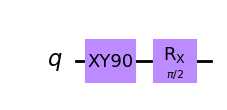

In [6]:
# # Draw the circuit of your choice: first index is the sequence, second index is the depth index in depths array
# for s, d_ in singularity[0:2]:
    # print(s, d_)
circuits_list[0][0].draw("mpl", style="clifford")
# print(circuits_list[s][d_])

In [7]:
for s, d_ in singularity:
    print(expected_probs[s, d_])

In [8]:
idx = 0
print("seqs: %s, depths: %s" %(seqs, depths))
for s in range(seqs):
    for id, d in enumerate(depths):
        print("circuit of seqs-%s, depths-%s:\n %s" %(s+1, d, circuits_list[s][id]))
        for d_ in range(d):
            print(f"cycle-{d_+1}")
            for q in range(len(qubits)):
                print(f'a{q+1}:\n')
                print([a[f"a{q+1}_{bin(i)[2:].zfill(2)}"][idx] for i in range(4)])
            idx += 1

seqs: 30, depths: [  1  21  41  61  81 101 121 141 161 181]
circuit of seqs-1, depths-1:
    ┌──────┐┌─────────┐
q: ┤ XY90 ├┤ Rx(π/2) ├
   └──────┘└─────────┘
cycle-1
a1:

[1.0, 0.0, 0.0, 1.0]
circuit of seqs-1, depths-21:
    ┌──────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐»
q: ┤ XY90 ├┤ Ry(π/2) ├┤ Rx(π/2) ├┤ Unitary ├┤ Rx(π/2) ├┤ Unitary ├┤ Ry(π/2) ├»
   └──────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
«   ┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐»
«q: ┤ Rx(π/2) ├┤ Unitary ├┤ Ry(π/2) ├┤ Unitary ├┤ Rx(π/2) ├┤ Unitary ├»
«   └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
«   ┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐»
«q: ┤ Rx(π/2) ├┤ Ry(π/2) ├┤ Rx(π/2) ├┤ Unitary ├┤ Ry(π/2) ├┤ Unitary ├»
«   └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
«   ┌─────────┐┌─────────┐┌─────────┐
«q: ┤ Ry(π/2) ├┤ Rx(π/2) ├┤ Ry(π/2) ├
«   └─────────┘└─────────┘└────

<0> Measured
data: [[0.13476562 0.30078125 0.37207031 0.18164062 0.13574219 0.33886719
  0.3515625  0.17773438 0.3046875  0.3515625 ]
 [0.11523438 0.34277344 0.31542969 0.18847656 0.21777344 0.34570312
  0.36523438 0.31152344 0.27734375 0.20800781]
 [0.1171875  0.14355469 0.26269531 0.26855469 0.31445312 0.12695312
  0.23535156 0.15917969 0.32617188 0.18164062]
 [0.06542969 0.34082031 0.24804688 0.32324219 0.33984375 0.12597656
  0.25195312 0.11035156 0.22167969 0.2890625 ]
 [0.1171875  0.17675781 0.12207031 0.3671875  0.38085938 0.28515625
  0.20800781 0.3359375  0.18945312 0.35253906]
 [0.13769531 0.42285156 0.38183594 0.20898438 0.2421875  0.29296875
  0.24511719 0.33007812 0.34179688 0.26269531]
 [0.14257812 0.35839844 0.13183594 0.26953125 0.37304688 0.4296875
  0.38378906 0.30761719 0.15820312 0.26171875]
 [0.06835938 0.06054688 0.14160156 0.41503906 0.171875   0.22070312
  0.390625   0.19824219 0.16015625 0.20507812]
 [0.10644531 0.30371094 0.19824219 0.13476562 0.15429688 0.217

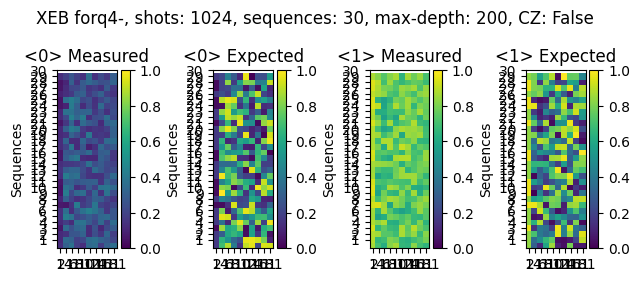

In [9]:

# Plot the results
def create_subplot(data, subplot_number, title):
    print(title)
    print("data: %s" % data)
    print(subplot_number)
    plt.subplot(subplot_number)
    plt.pcolor(depths, range(seqs), np.abs(data), vmin=0., vmax=1.)
    # plt.pcolor(depths, range(seqs), np.abs(data))
    ax = plt.gca()
    ax.set_title(title)
    if subplot_number > 244: ax.set_xlabel('Circuit depth')
    ax.set_ylabel('Sequences')
    ax.set_xticks(depths)
    ax.set_yticks(np.arange(1, seqs + 1))
    plt.colorbar()


titles, data = [], []
for i in range(2**len(qubits)):
    titles.append(f"<{bin(i)[2:].zfill(len(qubits))}> Measured")
    titles.append(f"<{bin(i)[2:].zfill(len(qubits))}> Expected")
    data.append(measured_probs[:, :, i])
    data.append(expected_probs[:, :, i])

plot_number = [241, 242, 243, 244, 245, 246, 247, 248]

k = 0
for title, d, n in zip(titles, data, plot_number):

    # if k%2 == 0:
    # plt.figure()
    # if k==0:
    qubits_involved = ""
    for q in qubits:
        qubits_involved += f"q{q}-"
    plt.suptitle(f"XEB for"+ qubits_involved+f", shots: {avgs}, sequences: {seqs}, max-depth: {max_depth}, CZ: {apply_cz}")
    create_subplot(d, n, title)
    plt.subplots_adjust(wspace=0.1, hspace=0.7)
    k+=1

    plt.tight_layout()
    plt.ion()


In [10]:
import pandas as pd
df = pd.DataFrame(records)
df["y"] = df["m_u"] - df["u_u"]
df["x"] = df["e_u"] - df["u_u"]

df["numerator"] = df["x"] * df["y"]
df["denominator"] = df["x"] ** 2
df


sequence  depth          pure_probs                 sampled_probs  \
0           0      1  [0.16667, 0.83333]    [0.134765625, 0.865234375]   
1           0     21  [0.69308, 0.30692]      [0.30078125, 0.69921875]   
2           0     41  [0.88182, 0.11818]  [0.3720703125, 0.6279296875]   
3           0     61  [0.41343, 0.58657]    [0.181640625, 0.818359375]   
4           0     81  [0.14598, 0.85402]  [0.1357421875, 0.8642578125]   
..        ...    ...                 ...                           ...   
295        29    101  [0.96524, 0.03476]          [0.359375, 0.640625]   
296        29    121  [0.00317, 0.99683]  [0.1376953125, 0.8623046875]   
297        29    141    [0.2446, 0.7554]  [0.2236328125, 0.7763671875]   
298        29    161  [0.23602, 0.76398]  [0.1591796875, 0.8408203125]   
299        29    181  [0.54885, 0.45115]  [0.2919921875, 0.7080078125]   

                                               circuit       e_u  u_u  \
0    ((Instruction(name='unitary', num_qubits=1, nu...  0.722218  0.5   
1    ((Instruction(name='unitary', num_qubits=1, nu...  0.574560  0.5   
2    ((Instruction(name='unitary', num_qubits=1, nu...  0.791573  0.5   
3    ((Instruction(name='unitary', num_qubits=1, nu...  0.514989  0.5   
4    ((Instruction(name='unitary', num_qubits=1, nu...  0.750660  0.5   
..                                                 ...       ...  ...   
295  ((Instruction(name='unitary', num_qubits=1, nu...  0.932897  0.5   
296  ((Instruction(name='unitary', num_qubits=1, nu...  0.993680  0.5   
297  ((Instruction(name='unitary', num_qubits=1, nu...  0.630458  0.5   
298  ((Instruction(name='unitary', num_qubits=1, nu...  0.639371  0.5   
299  ((Instruction(name='unitary', num_qubits=1, nu...  0.504773  0.5   

          m_u         y         x  numerator  denominator  
0    0.743487  0.243487  0.222218   0.054107     0.049381  
1    0.423070 -0.076930  0.074560  -0.005736     0.005559  
2    0.402308 -0.097692  0.291573  -0.028484     0.085015  
3    0.555121  0.055121  0.014989   0.000826     0.000225  
4    0.757909  0.257909  0.250660   0.064648     0.062831  
..        ...       ...       ...        ...          ...  
295  0.369151 -0.130849  0.432897  -0.056644     0.187399  
296  0.860008  0.360008  0.493680   0.177729     0.243720  
297  0.641168  0.141168  0.130458   0.018417     0.017019  
298  0.679939  0.179939  0.139371   0.025078     0.019424  
299  0.479678 -0.020322  0.004773  -0.000097     0.000023  

[300 rows x 12 columns]

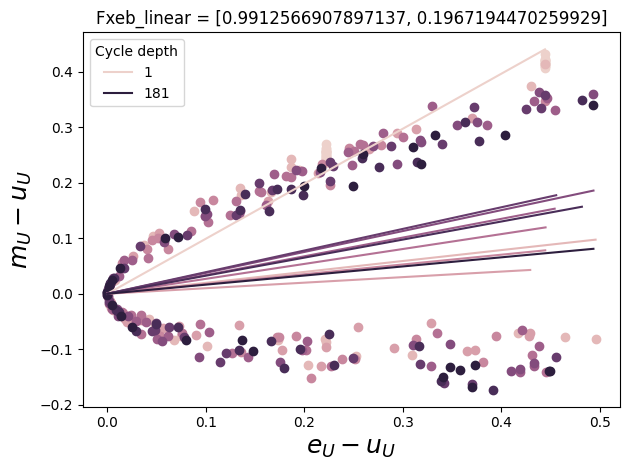

In [11]:
colors = sns.cubehelix_palette(n_colors=len(depths))
colors = {k: colors[i] for i, k in enumerate(depths)}

_lines = []


def per_cycle_depth(df):
    fid_lsq = df["numerator"].sum() / df["denominator"].sum()

    cycle_depth = df.name
    xx = np.linspace(0, df["x"].max())
    (l,) = plt.plot(xx, fid_lsq * xx, color=colors[cycle_depth])
    plt.scatter(df["x"], df["y"], color=colors[cycle_depth])

    global _lines
    _lines += [l]  # for legend
    return pd.Series({"fidelity": fid_lsq})


fids = df.groupby("depth").apply(per_cycle_depth).reset_index()
plt.xlabel(r"$e_U - u_U$", fontsize=18)
plt.ylabel(r"$m_U - u_U$", fontsize=18)
_lines = np.asarray(_lines)
plt.legend(_lines[[0, -1]], depths[[0, -1]], loc="best", title="Cycle depth")
plt.title("Fxeb_linear = %s" %[fids["fidelity"][x] for x in [0, 1]])
plt.tight_layout()


/var/folders/lz/657q9ypj0pd6l1g7f0wk81hm0000gn/T/ipykernel_66242/1557307292.py:54: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  slope, intercept, _, _, _ = stats.linregress(cycle_depths_pos, log_fidelities)


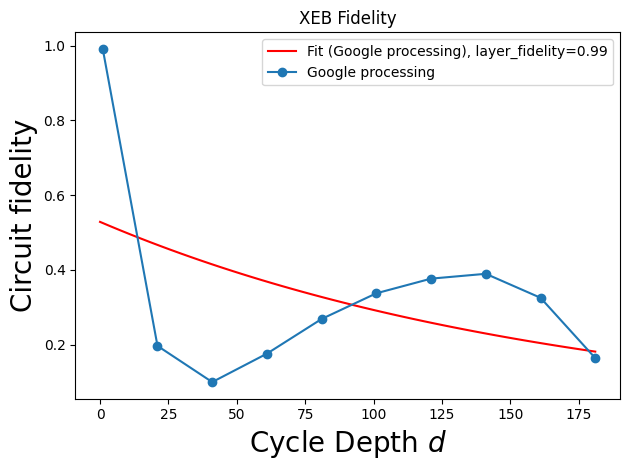

In [16]:
from scipy.stats import stats
from scipy import optimize

plot_log_XEB = 0

# Fit the data
def exponential_decay(cycle_depths: np.ndarray, a: float, layer_fid: float) -> np.ndarray:
    """An exponential decay for fitting.

    This computes `a * layer_fid**cycle_depths`

    Args:
        cycle_depths: The various depths at which fidelity was estimated. This is the independent
            variable in the exponential function.
        a: A scale parameter in the exponential function.
        layer_fid: The base of the exponent in the exponential function.
    """
    return a * layer_fid**cycle_depths

def _fit_exponential_decay(
    cycle_depths: np.ndarray, fidelities: np.ndarray
) -> Tuple[float, float, float, float]:
    """Fit an exponential model fidelity = a * layer_fid**x using nonlinear least squares.

    This uses `exponential_decay` as the function to fit with parameters `a` and `layer_fid`.

    Args:
        cycle_depths: The various depths at which fidelity was estimated. Each element is `x`
            in the fit expression.
        fidelities: The estimated fidelities for each cycle depth. Each element is `fidelity`
            in the fit expression.

    Returns:
        a: The first fit parameter that scales the exponential function, perhaps accounting for
            state prep and measurement (SPAM) error.
        layer_fid: The second fit parameters which serves as the base of the exponential.
        a_std: The standard deviation of the `a` parameter estimate.
        layer_fid_std: The standard deviation of the `layer_fid` parameter estimate.
    """
    cycle_depths = np.asarray(cycle_depths)
    fidelities = np.asarray(fidelities)

    # Get initial guess by linear least squares with logarithm of model.
    # This only works for positive fidelities. We use numpy fancy indexing
    # with `positives` (an ndarray of bools).
    positives = fidelities > 0
    if np.sum(positives) <= 1:
        # The sum of the boolean array is the number of `True` entries.
        # For one or fewer positive values, we cannot perform the linear fit.
        return 0, 0, np.inf, np.inf
    cycle_depths_pos = cycle_depths[positives]
    log_fidelities = np.log(fidelities[positives])

    slope, intercept, _, _, _ = stats.linregress(cycle_depths_pos, log_fidelities)
    layer_fid_0 = np.clip(np.exp(slope), 0, 1)
    a_0 = np.clip(np.exp(intercept), 0, 1)

    try:
        (a, layer_fid), pcov = optimize.curve_fit(
            exponential_decay,
            cycle_depths,
            fidelities,
            p0=(a_0, layer_fid_0),
            bounds=((0, 0), (1, 1)),
        )
    except ValueError:  # pragma: no cover
        return 0, 0, np.inf, np.inf

    a_std, layer_fid_std = np.sqrt(np.diag(pcov))
    return a, layer_fid, a_std, layer_fid_std

fit_google = True
fit_log_entropy = True
xx = np.linspace(0, fids["depth"].max())
# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
try:
    a, layer_fid, a_std, layer_fid_std = _fit_exponential_decay(fids["depth"], fids["fidelity"])
    plt.plot(xx, exponential_decay(xx, a, layer_fid),
         label='Fit (Google processing), layer_fidelity={:.2f}'.format(layer_fid),
         color='red')
except:
    # raise
    print("Fit for Google processing data failed")
    fit_google = False
Fxeb = np.mean(fidelities, axis=0)
try:
    a2, layer_fid2, a_std2, layer_fid_std2 = _fit_exponential_decay(depths, Fxeb)
    if plot_log_XEB:
        plt.plot(xx, exponential_decay(xx, a2, layer_fid2),
            label="Fit (Log-entropy processing), layer_fidelity={:.2f}".format(layer_fid2),
            color="green")
    
except:
    print("Fit for Log-entropy processing data failed")
    fit_log_entropy = False
    
    
plt.plot(fids["depth"], fids["fidelity"], marker="o", label="Google processing")

if plot_log_XEB:
    plt.scatter(depths, Fxeb, marker = 'o', color='green', label="Log-entropy processing")

plt.ylabel("Circuit fidelity", fontsize=20)
plt.xlabel("Cycle Depth $d$", fontsize=20)
plt.title("XEB Fidelity")
plt.legend(loc="best")
# plt.yscale("log")
plt.tight_layout()
plt.show()

In [14]:
if fit_google:
    print("Google processing fit:")
    print("Params: ", a, layer_fid)
    print("layer-fidelity: ", layer_fid)
if fit_log_entropy:
    print("Log-entropy processing fit:")
    print("Params: ", a2, layer_fid2)
    print("layer-fidelity: ", layer_fid2)

Google processing fit:
Params:  0.5285939910173779 0.9941105684592774
layer-fidelity:  0.9941105684592774
Log-entropy processing fit:
Params:  0.4540977702683617 0.9999999999999999
layer-fidelity:  0.9999999999999999


In [20]:
print(f"Currently used in the QM XEB example:\n {Fxeb}") # Derived from the fSim paper
print(f'Linear XEB of Google:\n {fids["fidelity"]}') # from Google's Supremacy paper

Currently used in the QM XEB example:
 [ 1.07361278 -0.06695234  0.27140266  0.11881103 -0.22514066 -0.56425527
 -0.53269657 -0.62966551  1.07289974  0.11561623]
Linear XEB of Google:
 0    1.004799
1   -0.193887
2   -0.089401
3    0.840161
4   -0.033615
5    0.643071
6    0.354790
7    0.166521
8    0.551650
9    0.220569
Name: fidelity, dtype: float64


In [38]:
print("relative difference", np.abs(fids["fidelity"] - Fxeb))

relative difference 0    0.615513
1    0.583009
Name: fidelity, dtype: float64


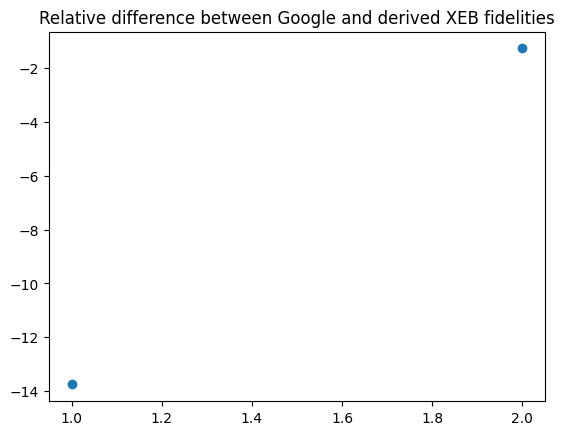

In [39]:
plt.title("Relative difference between Google and derived XEB fidelities")
plt.plot(depths, (fids["fidelity"]-Fxeb)/Fxeb, 'o', label="XEB fidelity")
